In this Exploratory Data Analysis (EDA), we:
- Explored the dataset using methods such as head(), shape, and info() to understand its structure.
- Checked for null values, outliers, and duplicates within the dataset.
- Removed outliers that were impossible or unrealistic.
- Split the data into training and test sets before analyzing feature correlations or feature-target relationships to avoid learning patterns from the test set.
- Analyzed feature correlations using a Pearson correlation matrix.
- Assessed feature-target relationships using mutual information and visualized patterns with Seaborn pairplots.
- Selected features to keep based on these analyses and saved the processed data into training and test sets.
- Chose three baseline models for initial training: Logistic Regression, Random Forest, and Gradient Boosting.

In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

### **Importing libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from src.utils import histogram_feature, correlation_matrix, categorical_cardinality, compute_mutual_info

### **Importing Data**

In [3]:
weather_data = pd.read_csv("../data/01_raw/weather_classification_data.csv")
weather_data.head(10)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
5,32.0,55,3.5,26.0,overcast,1010.03,2,Summer,5.0,inland,Cloudy
6,-2.0,97,8.0,86.0,overcast,990.87,1,Winter,4.0,inland,Snowy
7,3.0,85,6.0,96.0,partly cloudy,984.46,1,Winter,3.5,inland,Snowy
8,3.0,83,6.0,66.0,overcast,999.44,0,Winter,1.0,mountain,Snowy
9,28.0,74,8.5,107.0,clear,1012.13,8,Winter,7.5,coastal,Sunny


### **Understanding the dataset**

In [4]:
weather_data.shape

(13200, 11)

In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


- Within the **features** we have 4 **categorical** columns and 7 **numerical** columns
- As we can see we don't have any **null values** in the dataset

In [6]:
weather_data.isna().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

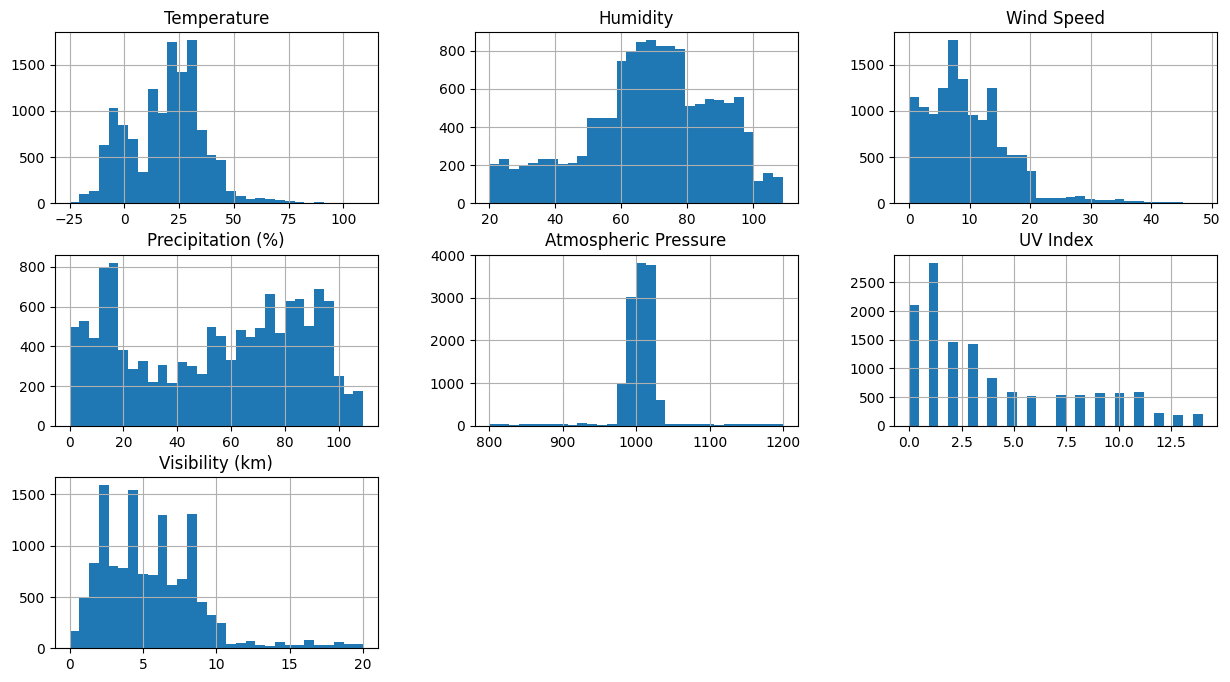

In [7]:
histogram_feature(data=weather_data)

There are several numerical features distribution that caught our attention and can be considered as outliers in our dataset: 

- Temperature highest record is 56.7 Celsius degrees and in this dataset are values that are going above

- Humidity is a percentual value, and are values that are higher than 100%. Same with the precipitation feature

- The normal sea-level pressure is 1013 hPa, and the highest one ever registered is 1084 hPa in the Everest, and there are some values a lot higher and some also too low, everything below 950 hPa should be also considered as outliers.

Skewed features:

- Wind Speed (to the right)

- UV Index (to the right)

- Visibility (to the right)

### **Removing outliers**

In [8]:
# Making a copy
weather_data_clean = weather_data.copy()

# Remove unrealistic temperature values
weather_data_clean = weather_data_clean[~(weather_data_clean['Temperature'] > 55)]

# Remove invalid humidity values
weather_data_clean = weather_data_clean[~(weather_data_clean['Humidity'] > 100)]

# Remove invalid precipitation values
weather_data_clean = weather_data_clean[~(weather_data_clean['Precipitation (%)'] > 100)]

# Keep only realistic atmospheric pressure values (950–1013 hPa)
weather_data_clean = weather_data_clean[
    (weather_data_clean['Atmospheric Pressure'] >= 950) &
    (weather_data_clean['Atmospheric Pressure'] <= 1013)
]
weather_data_clean.reset_index(drop=True, inplace=True)
weather_data_clean.shape

(7389, 11)

In [9]:
data_lost = 100 - ((weather_data.shape[0] - weather_data_clean.shape[0]) / 100)
print(f'Data lost after cleaning: {data_lost:.2f}%')

Data lost after cleaning: 41.89%


- A significant portion of the data was removed, however these values were invalid and therefore not useful for analysis.

In [10]:
weather_data_clean.head(10)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
3,32.0,55,3.5,26.0,overcast,1010.03,2,Summer,5.0,inland,Cloudy
4,-2.0,97,8.0,86.0,overcast,990.87,1,Winter,4.0,inland,Snowy
5,3.0,85,6.0,96.0,partly cloudy,984.46,1,Winter,3.5,inland,Snowy
6,3.0,83,6.0,66.0,overcast,999.44,0,Winter,1.0,mountain,Snowy
7,-10.0,87,15.0,67.0,overcast,986.19,0,Winter,1.5,inland,Snowy
8,10.0,50,6.5,46.0,partly cloudy,1000.44,2,Summer,8.5,mountain,Cloudy
9,33.0,51,0.5,27.0,overcast,1009.18,3,Autumn,5.5,coastal,Cloudy


### **Checking for duplicates**

In [11]:
weather_data_clean.duplicated().sum()

np.int64(0)

- We don't have any **duplicate** in out dataframe

### **Categorical features cardinality**

In [12]:
cardinalities = categorical_cardinality(weather_data_clean)
cardinalities

{'Cloud Cover': 4, 'Season': 4, 'Location': 3, 'Weather Type': 4}

- All our categorical features have low cardinality. We will use One Hot Encoding for these features in the preprocessing pipeline.

### **Data splitting** 

In [13]:
X = weather_data_clean.drop(columns=['Weather Type'])
y = weather_data_clean['Weather Type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

data_train = X_train.join(y_train)
data_test = X_test.join(y_test)

- The dataset was split into training and testing sets before examining correlations among features and feature-target relationships, to prevent learning patterns from the test set
- Stratification was applied to maintain consistent class proportions between the training and test sets

### **Features Correlation**

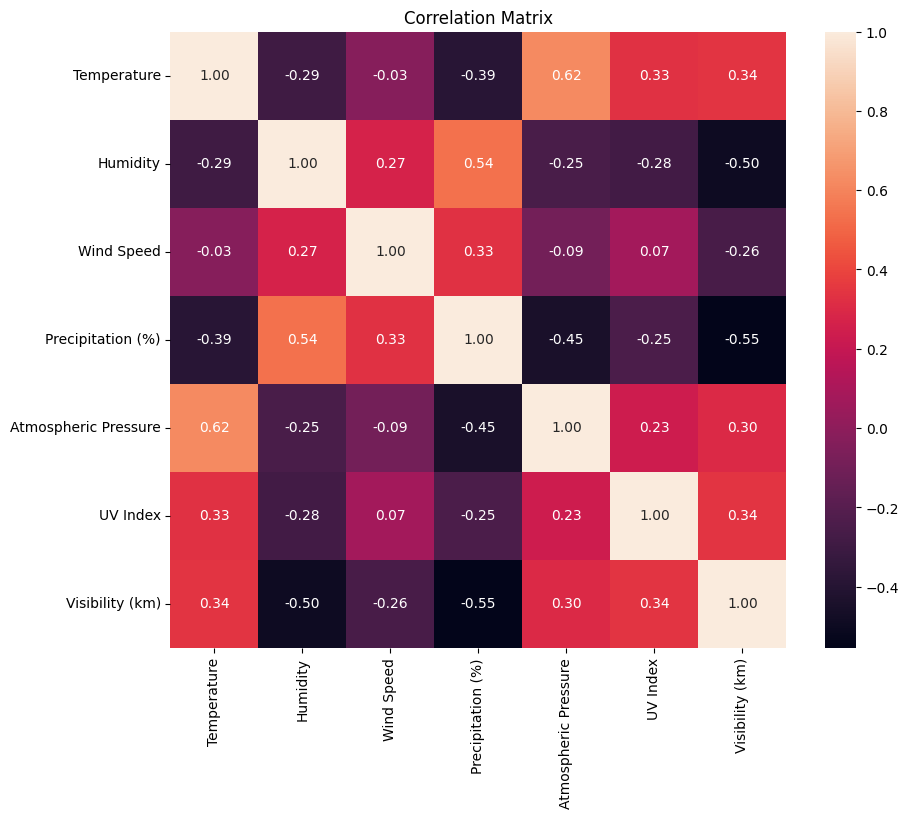

In [14]:
correlation_matrix(data=data_train)

- The Pearson correlation matrix reveals linear relationships among several features. In particular, **Precipitation** and **Humidity** show stronger correlations, and both are inversely proportional to **Visibility**. Also **Temperature** and **Atmospheric Pressure** are related, and this can be because both are strongly correlated with height.
- As we have moderate correlated features (linear correlation) a **linear model** can be a good candidate to train.

### **Feature-target Correlation**

In [15]:
mi_info = compute_mutual_info(data=data_train)
mi_info

Temperature             0.642889
Atmospheric Pressure    0.594223
Precipitation (%)       0.552890
Visibility (km)         0.500372
UV Index                0.394140
Season                  0.302059
Humidity                0.269885
Cloud Cover             0.192018
Wind Speed              0.134170
Location                0.113221
dtype: float64

- Mutual information analysis indicates that **Temperature**, **Atmospheric Pressure**, **Precipitation**, and **Visibility** are the most informative features for predicting the target. **Wind Speed**, **Location**, and **Cloud Cover** show very low mutual information and may have minimal impact on model performance. These features will be initially included in the baseline model to assess their contribution, and may be removed later based on feature importance

In [16]:
# Save cleaned data
data_train.to_csv('../data/02_clean/cleaned_train_data.csv', index=False)
data_test.to_csv('../data/02_clean/cleaned_test_data.csv', index=False)

- Now that we know that we won't remove any feature for the moment we can save our cleaned data.

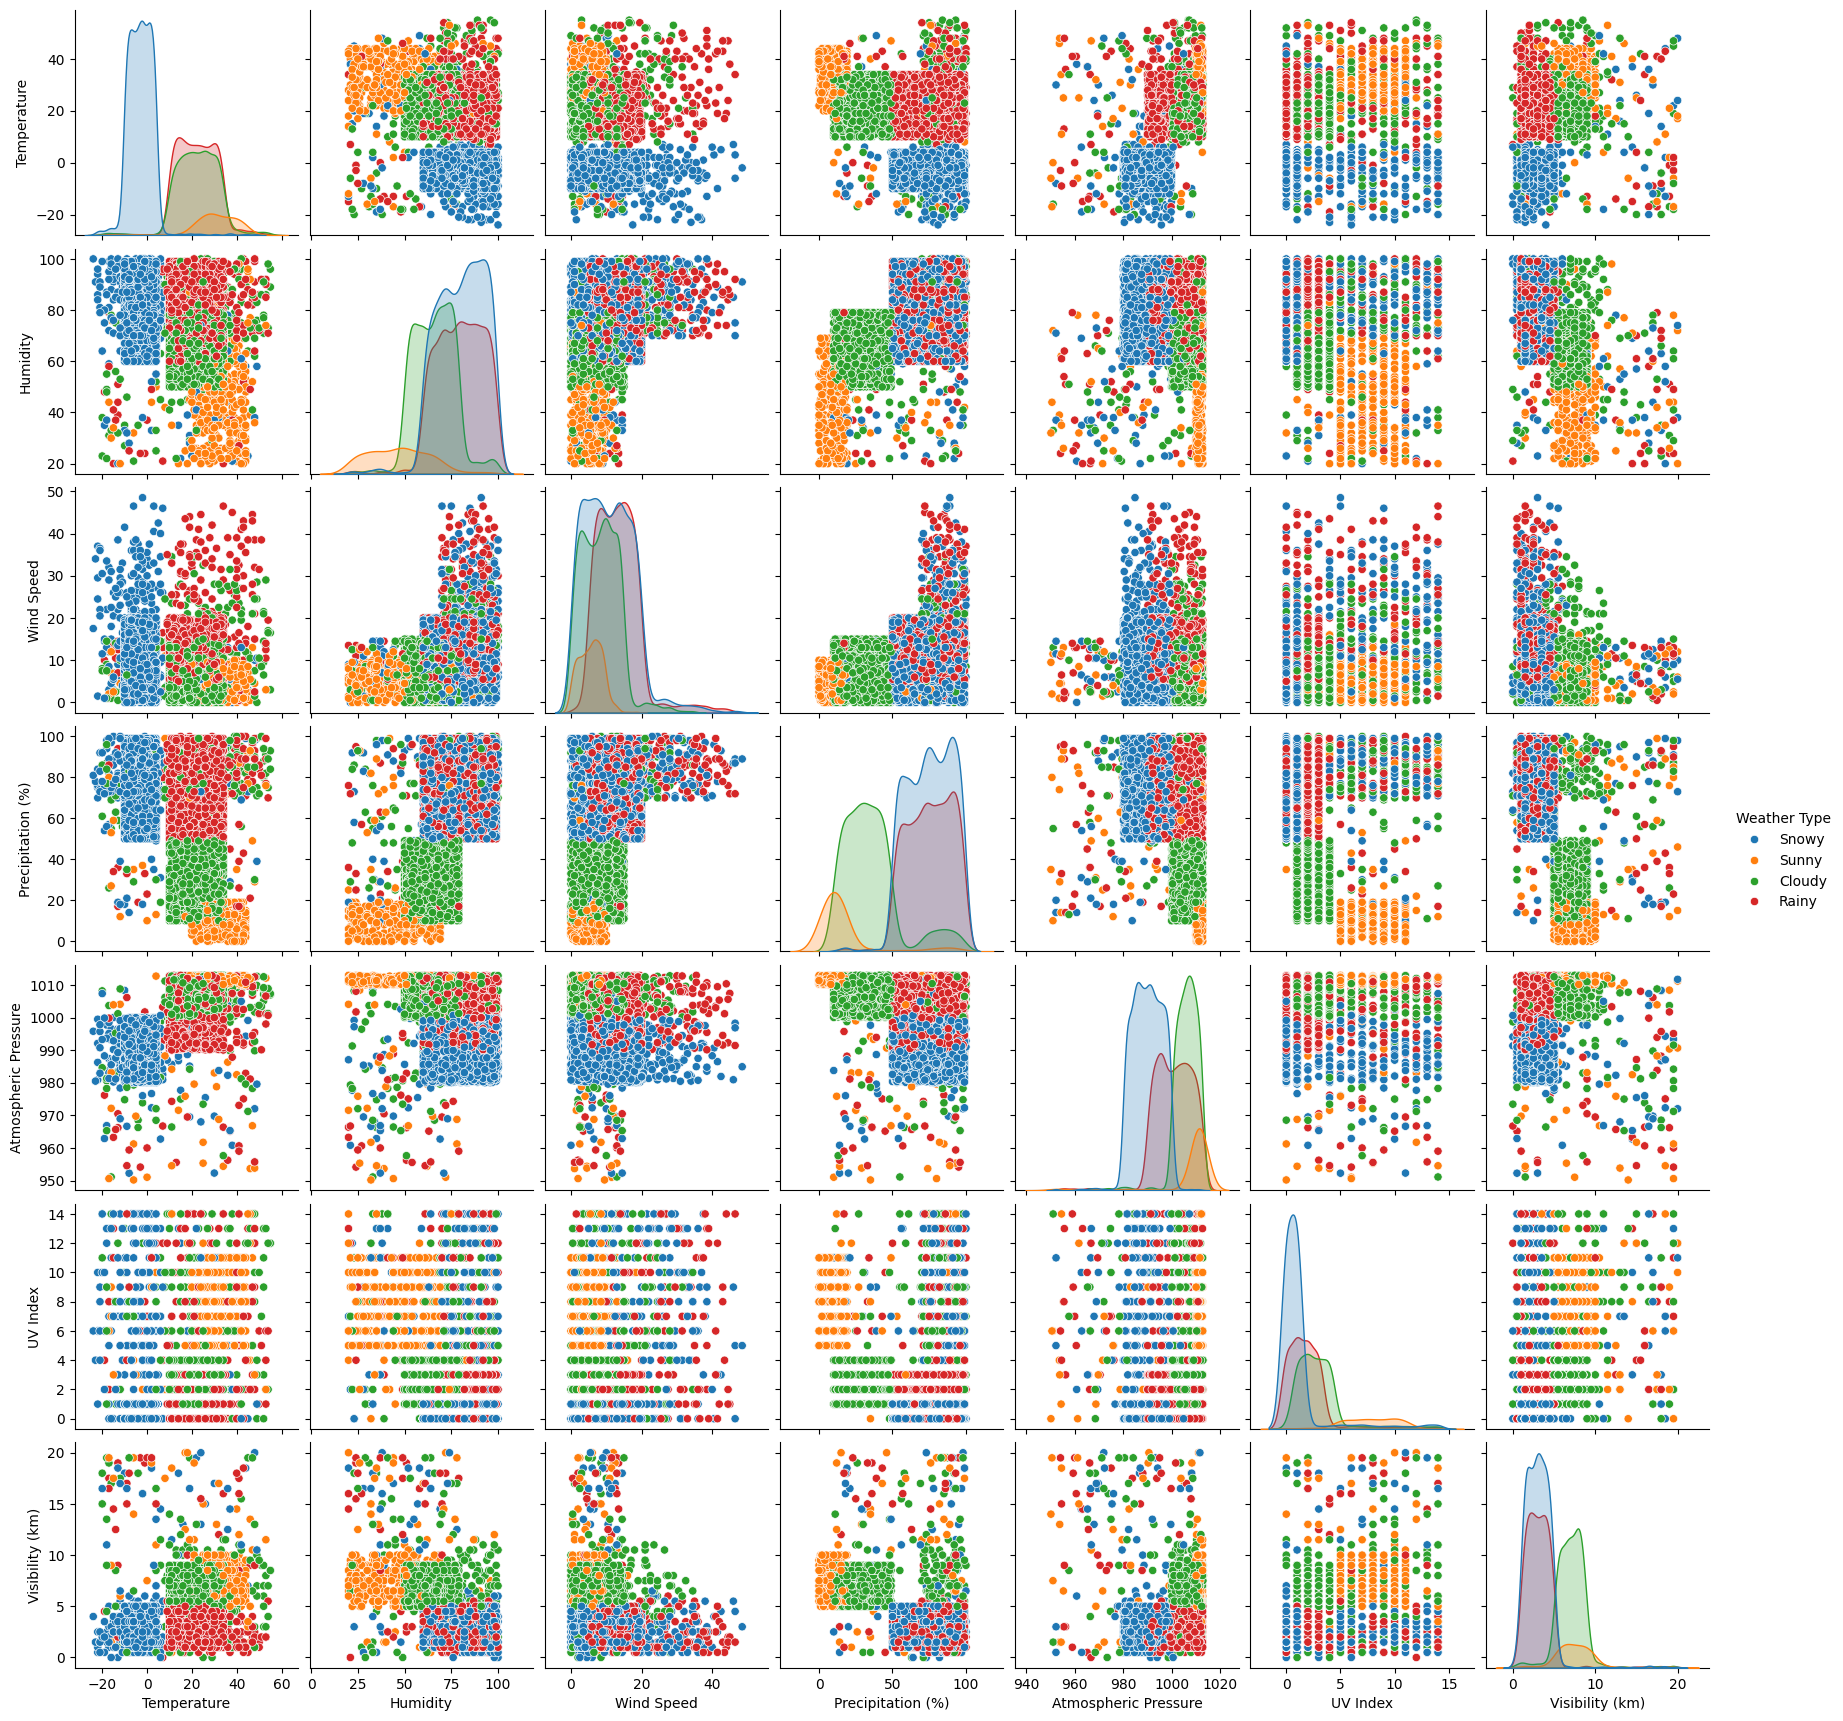

In [17]:
sns.pairplot(data=data_train, hue='Weather Type', diag_kind='kde')

- Individual feature distributions (KDE plots) do not show clear separation between target classes.
- Certain feature pairs reveal class separation, for example: **Precipitation** vs **Temperature** and **Temperature** vs **Humidity**.
- Humidity and Precipitation may contain redundant information.
- For the baseline models, we selected **Logistic Regression**, **Random Forest**, and **Gradient Boosting**.